# Neural Quantum Dynamics Emulator (Part II)

### Scope of this notebook

1. We define the configurations for training.
2. We define the benchmark models.
3. We run training on demo dataset.
4. We show the demo models test results.

In [1]:
# Standard libraries
import os
import time
import datetime

# Computation Libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from optimization import create_optimizer

#Graphic Libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#Custom Libraries
from emulator.utils import *

## Section 3: Training Setups

### 3.1 Configurations

The critical model and training settings are provided bellow.

In [2]:
class Config:
    def __init__(self, **kwargs):
        """ Configuration Settings for Training and Models"""
        
        #Read/write Settings
        self.qdml_tfrecords = "../datasets/demo/tfrecords/*"
        self.model_name = "demo"
        self.models_dir = "../models_checkpoints/"
        self.log_name = None

        #Training Settings
        self.train_batch = 128
        self.input_frames = 4
        self.input_channels = 3
        self.output_channels = 2
        self.window_size = 23
        self.dropout_rate = 0.
        self.hidden_size = 69
        self.num_train_steps = 900000 #5290000 for full dataset

        #Optimizer Settings
        self.learning_rate = 1e-3
        self.lr_decay_power = 1.0
        self.weight_decay_rate = 0.01
        self.num_warmup_steps = 9000 # 52900 for full dataset
        self.opt_beta_1 = 0.9
        self.opt_beta_2 = 0.999
        self.end_lr = 1e-6
        self.clip_norm = 1.0
        
        #Misc
        self.seed = 711
        self.logging_steps = 1000
        self.save_ckpt_steps = 1000000
        
        self.update(kwargs)        
        self.model_dir = os.path.join(self.models_dir, self.model_name)
        self.log_dir = os.path.join(self.model_dir, "logs")
        self.ckpts = os.path.join(self.model_dir, "ckpts")
    
    def update(self, kwargs):
        for k, v in kwargs.items():
            if v is not None:
                self.__dict__[k] = v

config = Config()

### 3.2 Load dataset

Here we load the windowed-dataset generated from last notebook. In this code snippet, we generate a tensorflow dataset with shuffled and batched training data.

In [3]:
dataset = iter(get_dataset(config))

All shapes are: (Batch, (Time_steps,) Window_size, Channels)
Inputs shape: (128, 4, 23, 3)
labels shape: (128, 23, 2)


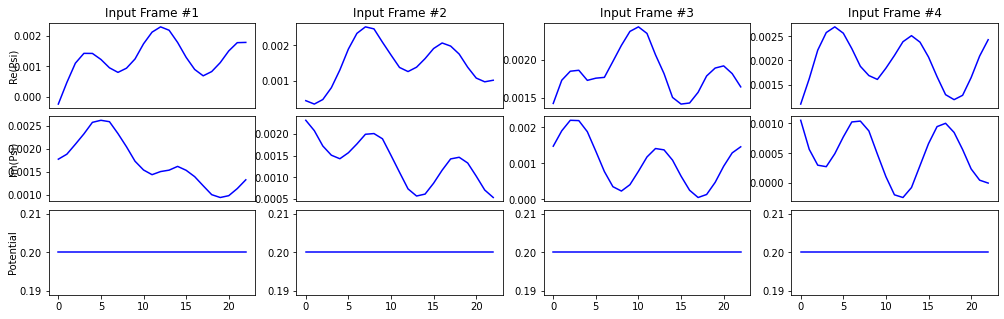

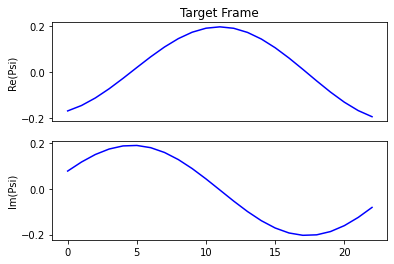

In [4]:
def plot_windows(config, feature, target):
    """ For any feature and target, plot all input frames and target frame"""
    plt.style.use('seaborn-pastel')
    ylabel = ["Re(Psi)", "Im(Psi)", "Potential"]
    
    #Plot the input frames
    fig = plt.figure(figsize=(17, 5))
    outer = gridspec.GridSpec(1, config.input_frames)
    
    for i in range(config.input_frames):
        inner = gridspec.GridSpecFromSubplotSpec(config.input_channels, 1, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
        for j in range(config.input_channels):
            ax = plt.Subplot(fig, inner[j])
            y = feature[i, :, j]
            ax.plot(y, c="blue")
            if j == 0:
                ax.set_title(f"Input Frame #{i+1}")
            if j != 2:
                ax.set_xticks([])
            if i == 0:
                ax.set_ylabel(ylabel[j])
                ax.yaxis.set_label_coords(-0.15, 0.5)
            fig.add_subplot(ax)
    
    #Plot the target frame
    fig2 = plt.figure()
    label = gridspec.GridSpec(config.output_channels,1)
    for i in range(2):
        ax = plt.Subplot(fig2,label[i])
        ax.plot(target[:,i],c='blue')
        ax.set_ylabel(ylabel[i])
        if i==0:
            ax.set_title("Target Frame")
            ax.set_xticks([])
        fig2.add_subplot(ax)

batch_feature, batch_target = next(dataset)
print('All shapes are: (Batch, (Time_steps,) Window_size, Channels)')
print(f'Inputs shape: {batch_feature.shape}')
print(f'labels shape: {batch_target.shape}')
plot_windows(config, batch_feature[2], batch_target[7])

## Section 4: Models

The minimal trainable model we can apply to this task is to insert linear transformation between the input and output. In this case, we choose to let the output only depend on the last timestep. This model is treated as the baseline model.

In [5]:
class LinearModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.last = layers.Lambda(lambda x: x[:, -1, :, :])
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.last(input_tensor)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.reshape(x)

        return x

conf_lin = Config(model_name="demo-lin")
m_lin = LinearModel(conf_lin)
m_lin.build((None, conf_lin.input_frames, conf_lin.window_size, conf_lin.input_channels))
m_lin.summary()

Model: "linear_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3220      
_________________________________________________________________
reshape (Reshape)            multiple                  0         
Total params: 3,220
Trainable params: 3,220
Non-trainable params: 0
_________________________________________________________________


We stack more linear layers to check the performance of a deeper and more expressive model. Moreover, the model takes multiple timesteps to see how the features change overtime before making predictions. ReLU activation function is used to introduce some non-linearities. 

In [6]:
class DenseModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.flatten = layers.Reshape((config.input_frames, config.window_size * config.input_channels))
        self.dense1 = layers.Dense(config.hidden_size, activation="relu")
        # conv1d equivlent to a dense layer here
        self.conv1d = layers.Conv1D(filters=config.hidden_size, kernel_size=(config.input_frames), activation='relu')
        self.dense2 = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.flatten(input_tensor)
        x = self.dense1(x)
        x = self.conv1d(x)
        x = self.dense2(x)
        x = self.reshape(x)
        return x


conf_dense = Config(model_name="demo-dense")
m_dense = DenseModel(conf_dense)
m_dense.build((None, conf_dense.input_frames, conf_dense.window_size, conf_dense.input_channels))
m_dense.summary()

Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  4830      
_________________________________________________________________
conv1d (Conv1D)              multiple                  19113     
_________________________________________________________________
dense_2 (Dense)              multiple                  3220      
_________________________________________________________________
reshape_2 (Reshape)          multiple                  0         
Total params: 27,163
Trainable params: 27,163
Non-trainable params: 0
_________________________________________________________________


A convolution layer can also take multiple time steps as input to make a prediction.

In [7]:
class CNNModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.flatten = layers.Flatten()
        self.conv1d =layers.Conv2D(filters=16, kernel_size=(config.input_frames, 1), activation='relu')
        self.dense1 = layers.Dense(config.hidden_size, activation="relu")
        self.dense2 = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.conv1d(input_tensor)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.reshape(x)
        return x
    
conf_conv = Config(model_name="demo-conv")
m_conv = CNNModel(conf_conv)
m_conv.build((None, conf_conv.input_frames, conf_conv.window_size, conf_conv.input_channels))
m_conv.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  208       
_________________________________________________________________
dense_3 (Dense)              multiple                  25461     
_________________________________________________________________
dense_4 (Dense)              multiple                  3220      
_________________________________________________________________
reshape_3 (Reshape)          multiple                  0         
Total params: 28,889
Trainable params: 28,889
Non-trainable params: 0
_________________________________________________________________


A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step by step and maintain an internal state from time-step to time-step. In this model, the recurrent layer warms up its internal state during first few timesteps and only returns the output of the final timestep. 

In [8]:
class RNNModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.flatten = layers.Reshape((config.input_frames, config.window_size * config.input_channels)) #Keep 2 dimenional instead of 1 dimensional and have reccurent in 1 dime
        self.dense1 = layers.Dense(config.hidden_size, activation="relu") #Try to remove and check
        self.gru = tf.keras.layers.GRU(config.hidden_size, return_state=True, activation='relu', dropout=config.dropout_rate)
        self.dense2 = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.flatten(input_tensor)
        x = self.dense1(x)
        output, final_state = self.gru(x, initial_state=None, training=training)
        x = tf.concat((output, final_state), axis=-1)
        x = self.dense2(x)
        x = self.reshape(x)
        return x

conf_gru = Config(model_name="demo-gru")
m_gru = RNNModel(conf_gru)
m_gru.build((None, conf_gru.input_frames, conf_gru.window_size, conf_gru.input_channels))
m_gru.summary()

Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  4830      
_________________________________________________________________
gru (GRU)                    multiple                  28980     
_________________________________________________________________
dense_6 (Dense)              multiple                  6394      
_________________________________________________________________
reshape_5 (Reshape)          multiple                  0         
Total params: 40,204
Trainable params: 40,204
Non-trainable params: 0
_________________________________________________________________


## Section 5: Training

In [9]:
def train(config, model):
    """ Main training loop """
    
    @tf.function #Uses XLA for faster training
    def train_step(feature, target, model, optimizer):
        mse = tf.keras.losses.MeanSquaredError()
        with tf.GradientTape() as tape:
            predict = model(feature, True)
            loss = mse(target, predict)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        clipped_gradients = [tf.clip_by_norm(g, config.clip_norm) for g in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))

        return loss
    
    #Seed for replication
    tf.random.set_seed(config.seed)
    
    #Logging during training
    log_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") if config.log_name is None else config.log_name
    train_log_dir = config.log_dir + "/" + log_name
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    f = open(train_log_dir + "/" + "config.txt", "w")
    f.write(str(config.__dict__))
    f.close()

    #Load dataset from config
    dataset = iter(get_dataset(config))
    
    
    #Optimizer
    optimizer, lr_schedule = create_optimizer(
        init_lr=config.learning_rate,
        num_train_steps=config.num_train_steps,
        num_warmup_steps=config.num_warmup_steps,
        weight_decay_rate=config.weight_decay_rate,
        power=config.lr_decay_power,
        adam_beta1=config.opt_beta_1,
        adam_beta2=config.opt_beta_2,
        min_lr_ratio=config.end_lr / config.learning_rate)
    
    tf.config.optimizer.set_jit(True)

    
    metrics = {"train_loss": tf.keras.metrics.Mean(name="train_loss")}

    step = 0
    start_time = logging_time = time.time()
    
    #Training for every step
    while step < config.num_train_steps:
        feature, target = next(dataset)
        loss = train_step(feature, target, model, optimizer)
        metrics["train_loss"].update_state(loss)

        step += 1
        if step % config.logging_steps == 0:
            print("Step: {:6d}, Loss: {:.8f}, Time per logging: {:.2f}s, Elapsed: {:}, ETA: {:}".format(
                step,
                metrics["train_loss"].result(),
                time.time() - logging_time,
                get_readable_time(time.time() - start_time),
                get_readable_time((time.time() - start_time) / step * (config.num_train_steps - step))), flush=True)
            with train_summary_writer.as_default():
                for k in metrics:
                    tf.summary.scalar(k, metrics[k].result(), step=step)
                    metrics[k].reset_states()
            logging_time = time.time()

        if step % config.save_ckpt_steps == 0 and step != config.num_train_steps:
            model.save_weights(os.path.join(config.ckpts, "step_" + str(step)))
            print("Model weights saved at ", os.path.join(config.ckpts, "step_" + str(step)))

    model.save_weights(os.path.join(config.ckpts, "final_step"))
    print("Model Trained!")
    print("Model weights saved at ", os.path.join(config.ckpts, "final_step"))

In [12]:
"""Training GRU model for demo dataset"""
conf_gru = Config(model_name="demo-gru")   #model_name = "full-gru" for the full dataset
m_gru = RNNModel(conf_gru)
train(conf_gru, m_gru)

Step:   1000, Loss: 0.00536922, Time per logging: 8.58s, Elapsed:  0h 0m 8s, ETA:  2h 8m30s
Step:   2000, Loss: 0.00076312, Time per logging: 7.26s, Elapsed:  0h 0m15s, ETA:  1h59m26s
Step:   3000, Loss: 0.00025804, Time per logging: 7.33s, Elapsed:  0h 0m23s, ETA:  1h56m21s
Step:   4000, Loss: 0.00013423, Time per logging: 7.37s, Elapsed:  0h 0m30s, ETA:  1h55m 7s
Step:   5000, Loss: 0.00010109, Time per logging: 7.37s, Elapsed:  0h 0m38s, ETA:  1h54m22s
(...)
Step: 896000, Loss: 0.00000054, Time per logging: 13.54s, Elapsed:  3h21m51s, ETA:  0h 0m54s
Step: 897000, Loss: 0.00000071, Time per logging: 14.01s, Elapsed:  3h22m 5s, ETA:  0h 0m40s
Step: 898000, Loss: 0.00000070, Time per logging: 16.26s, Elapsed:  3h22m21s, ETA:  0h 0m27s
Step: 899000, Loss: 0.00000054, Time per logging: 14.26s, Elapsed:  3h22m36s, ETA:  0h 0m13s
Step: 900000, Loss: 0.00000069, Time per logging: 13.38s, Elapsed:  3h22m49s, ETA:  0h 0m 0s
Model Trained!
Model weights saved at  ../models/demo-gru\ckpts\final

## Section 6: Demo Models Test

In [10]:
def plot_error(ckpts_list, test_file, pot_scalar=10.0, skip_frames=0, frames=400, norm=False):
    """Plot loss over time for all four type of models"""
    data = retrieve_data(test_file, pot_scalar)
    fig = plt.figure(figsize=(12,8))
    plt.title('Error comparison for different models')
    plt.xlabel('Time')
    plt.ylabel('Error (Log Scale)')
    for model, ckpt in ckpts_list:
        model.load_weights(ckpt)
        result = get_result(model, config, data, skip_frames, frames, normalization=norm)
        loss = get_loss(config, data, result, skip_frames, frames)
        plt.plot(loss, label=ckpt.split('/')[2])
    plt.yscale('log')
    plt.legend()
    plt.show()

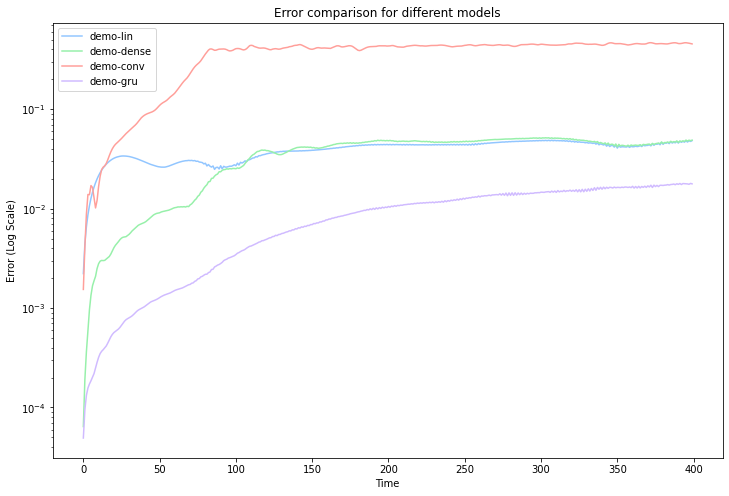

In [11]:
"""Error Comparison between models"""
ckpts_list = [
    (LinearModel(config), "../models/demo-lin/ckpts/final_step"),
    (DenseModel(config), "../models/demo-dense/ckpts/final_step"),
    (CNNModel(config), "../models/demo-conv/ckpts/final_step"),
    (RNNModel(config), "../models/demo-gru/ckpts/final_step")
]

"""This test case has a single potential barrier"""
plot_error(ckpts_list, "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/X0_15.1_S0_1.7_E0_6.4_BH_7.4_BW_9.4.txt")

In [12]:
#Save Loss and Correlations for all test cases
evaluate(config, ckpts_list, "../datasets/test/full_test_E0_0.0to9.0_BH_0.0to14.0/*.txt", "demo-results.npz")

Processed 1/100 (1.0%), ELAPSED:  0h 0m 5s, ETA:  0h 9m25s
Processed 2/100 (2.0%), ELAPSED:  0h 0m12s, ETA:  0h10m15s
Processed 3/100 (3.0%), ELAPSED:  0h 0m19s, ETA:  0h10m16s
Processed 4/100 (4.0%), ELAPSED:  0h 0m33s, ETA:  0h13m21s
Processed 5/100 (5.0%), ELAPSED:  0h 0m39s, ETA:  0h12m22s
(...)
Processed 96/100 (96.0%), ELAPSED:  0h13m30s, ETA:  0h 0m33s
Processed 97/100 (97.0%), ELAPSED:  0h13m37s, ETA:  0h 0m25s
Processed 98/100 (98.0%), ELAPSED:  0h13m44s, ETA:  0h 0m16s
Processed 99/100 (99.0%), ELAPSED:  0h13m50s, ETA:  0h 0m 8s
Processed 100/100 (100.0%), ELAPSED:  0h14m 4s, ETA:  0h 0m 0s


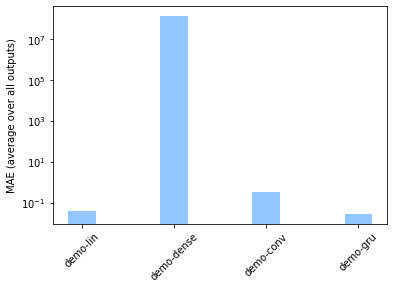

In [50]:
#Plot Mean and Standard Deviation of Error over all test files
npzfile = np.load("demo-results.npz")
x = np.arange(len(npzfile["ckpts"]))
all_loss = npzfile["all_loss"]
test_mae = np.mean(all_loss, axis = (1, 2))
plt.bar(x, test_mae, 0.3)
plt.xticks(ticks=x, labels=npzfile["ckpts"],rotation=45)
plt.ylabel('MAE (average over all outputs)')
plt.yscale('log')
plt.show()

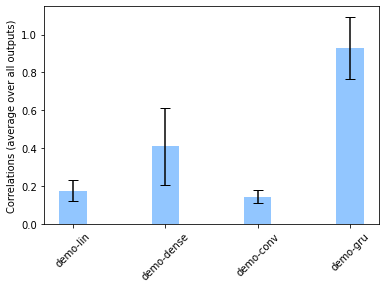

In [51]:
#Plot Mean and Standard Deviation of Correlation over all test files
npzfile = np.load("demo-results.npz")
x = np.arange(len(npzfile["ckpts"]))
all_corr = npzfile["all_corr"]
test_corr = np.mean(all_corr, axis = (1, 2))
test_std = np.std(np.mean(all_corr, axis = 2), axis = 1)
plt.bar(x, test_corr, 0.3, yerr=test_std, capsize=5)
plt.xticks(ticks=x, labels=npzfile["ckpts"],rotation=45)
plt.ylabel('Correlations (average over all outputs)')
plt.show()